# Recoleccion de datos


In [61]:
# fruit: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition?select=train
# fashion: https://github.com/zalandoresearch/fashion-mnist

# Procesamiento de datos

In [62]:
import torch
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [63]:
# Create a list with the filepaths for training and testing
train_dir = Path(r'C:\\Users\\fabian\\Documents\\Code USM\\RedesNeuronales\\fruits\\train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))


test_dir = Path(r'C:\\Users\\fabian\\Documents\\Code USM\\RedesNeuronales\\fruits\\test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(r'C:\\Users\\fabian\\Documents\\Code USM\\RedesNeuronales\\fruits\\validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)


In [64]:
print(f"Total training images: {len(train_filepaths)}")
print(f"Total test images: {len(test_filepaths)}")



Total training images: 350
Total test images: 43


In [65]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 350

Number of different labels: 5

Labels: ['lemon' 'carrot' 'lettuce' 'apple' 'banana']


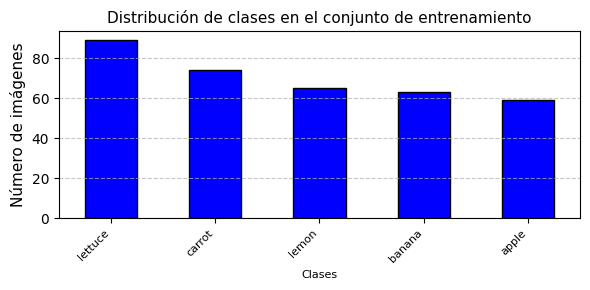

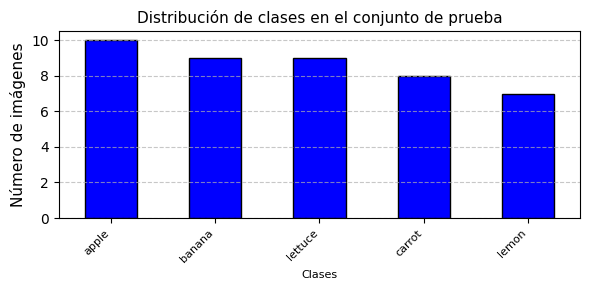

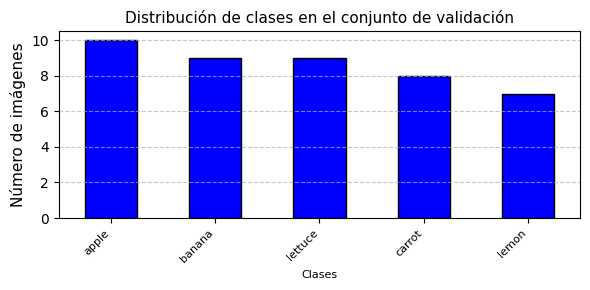

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para visualizar la distribución de clases
def plot_class_distribution(df, title):
    """
    Muestra un gráfico de barras con la distribución de clases en un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame con al menos una columna 'Label'.
        title (str): Título del gráfico.
    """
    # Contar la cantidad de imágenes por clase
    class_counts = df['Label'].value_counts()
    
    # Crear el gráfico
    plt.figure(figsize=(6, 3))
    class_counts.plot(kind='bar', color='blue', edgecolor='black')
    
    # Agregar etiquetas y título
    plt.title(title, fontsize=11)
    plt.xlabel('Clases', fontsize=8)
    plt.ylabel('Número de imágenes', fontsize=11)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# Visualizar la distribución en cada conjunto
plot_class_distribution(train_df, 'Distribución de clases en el conjunto de entrenamiento')
plot_class_distribution(test_df, 'Distribución de clases en el conjunto de prueba')
plot_class_distribution(val_df, 'Distribución de clases en el conjunto de validación')


In [67]:
import pandas as pd

# Crear un DataFrame vacío para almacenar los conteos
labels = sorted(set(train_df['Label']).union(test_df['Label']).union(val_df['Label']))
columns = ['train', 'val', 'test']
distribution_df = pd.DataFrame(index=labels, columns=columns)

# Contar las instancias por clase en cada conjunto y llenar el DataFrame
distribution_df['train'] = train_df['Label'].value_counts()
distribution_df['val'] = val_df['Label'].value_counts()
distribution_df['test'] = test_df['Label'].value_counts()

# Reemplazar NaN por 0 en caso de que una clase no esté presente en algún conjunto
distribution_df.fillna(0, inplace=True)

# Convertir los valores a enteros
distribution_df = distribution_df.astype(int)

# Mostrar el DataFrame
print(distribution_df)


         train  val  test
apple       59   10    10
banana      63    9     9
carrot      74    8     8
lemon       65    7     7
lettuce     89    9     9


In [68]:
# The DataFrame with the filepaths in one column and the labels in the other one
train_df.head(5)

,Filepath,Label
0,C:\Users\fabian\Documents\Code USM\RedesNeuron...,lemon
1,C:\Users\fabian\Documents\Code USM\RedesNeuron...,carrot
2,C:\Users\fabian\Documents\Code USM\RedesNeuron...,lettuce
3,C:\Users\fabian\Documents\Code USM\RedesNeuron...,apple
4,C:\Users\fabian\Documents\Code USM\RedesNeuron...,carrot


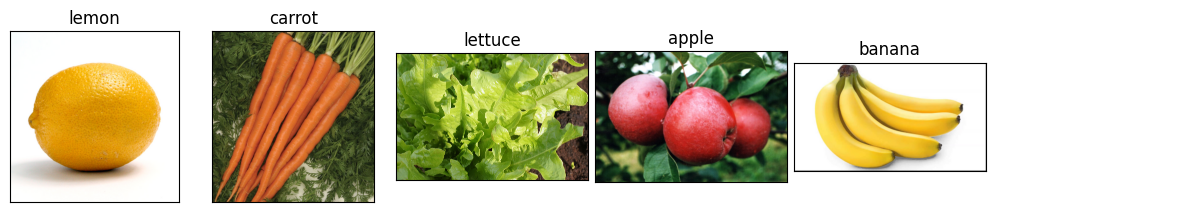

In [69]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Define the number of rows and columns based on the size of df_unique
num_images = len(df_unique)
ncols = 6
nrows = (num_images // ncols) + (num_images % ncols > 0)

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 2, nrows * 2),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten axes to handle cases with fewer images than subplots
axes = axes.flatten()

# Loop through the images and plot them
for i, ax in enumerate(axes):
    if i < num_images:
        ax.imshow(plt.imread(df_unique.Filepath[i]))
        ax.set_title(df_unique.Label[i], fontsize=12)
    else:
        ax.axis('off')  # Turn off axes for unused subplots

plt.tight_layout(pad=0.5)
plt.show()

In [70]:
train_df.head()

,Filepath,Label
0,C:\Users\fabian\Documents\Code USM\RedesNeuron...,lemon
1,C:\Users\fabian\Documents\Code USM\RedesNeuron...,carrot
2,C:\Users\fabian\Documents\Code USM\RedesNeuron...,lettuce
3,C:\Users\fabian\Documents\Code USM\RedesNeuron...,apple
4,C:\Users\fabian\Documents\Code USM\RedesNeuron...,carrot


In [71]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [72]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame con columnas 'Filepath' y 'Label'.
            transform (callable, optional): Transformaciones a aplicar a las imágenes.
        """
        self.filepaths = dataframe['Filepath'].values
        self.labels = dataframe['Label'].values
        self.transform = transform

        # Mapear etiquetas a índices
        self.label_to_index = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        # Cargar imagen
        image_path = self.filepaths[idx]
        image = Image.open(image_path).convert("RGB")

        # Obtener etiqueta y convertirla a índice
        label = self.labels[idx]
        label_idx = self.label_to_index[label]

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label_idx

In [73]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Redimensionar a 128x128 píxeles
    transforms.Resize((32, 32)),
    transforms.ToTensor(),         # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar
])


In [74]:
dataset_train = ImageDataset(dataframe=train_df, transform=transform)
dataset_test = ImageDataset(dataframe=test_df, transform=transform)
dataset_val = ImageDataset(dataframe=val_df, transform=transform)


In [75]:
batch_size = 4 # Elegir numero de muestras por batch

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

# CNN

torch.Size([6, 30, 30])
torch.Size([6, 15, 15])


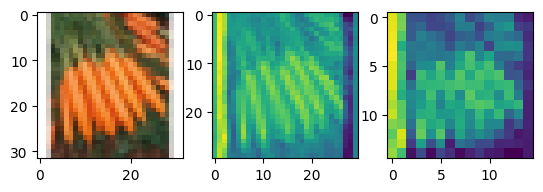

In [76]:
import torch.nn as nn
import torch.nn.functional as F

imagen_demo = dataset_train[12][0] # Seleccionar imagen
conv_demo = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3)
conv_image = conv_demo(imagen_demo)
print(conv_image.shape)

pool_demo = nn.MaxPool2d(2,2)
pool_image = pool_demo(conv_image)
print(pool_image.shape)

img = imagen_demo.permute(1,2,0).detach().numpy() / 2 + 0.5
conv_img = conv_image[0].detach().numpy()
pool_img = pool_image[0].detach().numpy()

fig, axs = plt.subplots(1,3)
axs[0].imshow(img)
axs[1].imshow(conv_img)
axs[2].imshow(pool_img)

plt.show()

In [77]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): # Para rellenar
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3) # seleccionar kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)  # (16 - tamaño_kernel)/stride + 1 -> 11px
                                          # A realizar pooling se debe dividir el canal en 2 y truncar la parte entera, 11/2->5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # n_canales * alto_imagen * ancho_imagen
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5) # capa de salida 5, por 5 clases

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnn = CNN()

In [78]:
# # CNN para 128px
# import torch.nn as nn
# import torch.nn.functional as F

# class CNN(nn.Module): 
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)  # Primer capa convolucional
#         self.pool = nn.MaxPool2d(2, 2)  # Pooling 2x2
#         self.conv2 = nn.Conv2d(6, 16, 5)  # Segunda capa convolucional
#         self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Capa totalmente conectada después de aplanar (16 * 29 * 29 = 13424)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 5)  # Capa de salida para 5 clases

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  # Primer convolucional + ReLU + Pooling
#         x = self.pool(F.relu(self.conv2(x)))  # Segundo convolucional + ReLU + Pooling
#         x = torch.flatten(x, 1)  # Aplanar la salida para la capa totalmente conectada
#         x = F.relu(self.fc1(x))  # Capa totalmente conectada 1 + ReLU
#         x = F.relu(self.fc2(x))  # Capa totalmente conectada 2 + ReLU
#         x = self.fc3(x)  # Capa de salida
#         return x

# cnn = CNN()


In [79]:
import torch.optim as optim
import torch.nn as nn

# Suponiendo que las etiquetas están codificadas como enteros (categorías):
criterion = nn.CrossEntropyLoss()  # Función de pérdida para clasificación multiclase

# Usar SGD como optimizador
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9) 

lr (Learning Rate):

Especifica el tamaño del paso de actualización de los parámetros.
Un valor típico para empezar es 0.01 o 0.1, pero puede ajustarse dependiendo del problema.
momentum (opcional):

Acelera el entrenamiento al dirigir los pasos del gradiente hacia direcciones consistentes.
Se recomienda usarlo (típicamente 0.9) para estabilizar el aprendizaje y superar oscilaciones.
weight_decay (opcional):

También conocido como regularización 
𝐿
2
L 
2
 , ayuda a prevenir el sobreajuste.
Se usa como: weight_decay=1e-4.

# Entrenamiento

In [80]:
EPOCHS = 5
losses = []
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = cnn(inputs)
        # backward
        loss = criterion(outputs, labels)
        loss.backward()
        # optimizacion
        optimizer.step()

        # print statistics
        epoch_loss += loss.item()

    average_loss = epoch_loss / len(trainloader)  # Calculate average loss for the epoch
    losses.append(average_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {average_loss:.4f}")

print('Entrenamiento finalizado')

Epoch 1/5, Loss: 1.5974
Epoch 2/5, Loss: 1.4495
Epoch 3/5, Loss: 1.2021
Epoch 4/5, Loss: 1.1658
Epoch 5/5, Loss: 1.0821
Entrenamiento finalizado


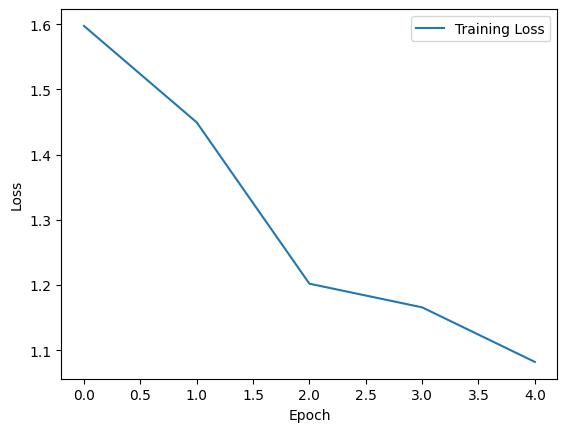

In [81]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
EPOCHS = 5
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    train_loss = 0.0
    cnn.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # setea los gradientes en 0
        optimizer.zero_grad()

        # forward
        outputs = cnn(inputs)
        # backward
        loss = criterion(outputs, labels)
        loss.backward()
        # optimizacion
        optimizer.step()

        # print statistics
        train_loss += loss.item()

    average_train_loss = train_loss / len(trainloader)
    train_losses.append(average_train_loss)

    val_loss = 0.0
    cnn.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    average_validation_loss = val_loss / len(testloader)
    val_losses.append(average_validation_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {average_train_loss:.4f}, Validation Loss: {average_validation_loss:.4f}")

print('Entrenamiento finalizado')

Epoch 1/5, Train Loss: 0.9233, Validation Loss: 0.6998
Epoch 2/5, Train Loss: 0.9307, Validation Loss: 1.1885
Epoch 3/5, Train Loss: 1.0651, Validation Loss: 0.9509
Epoch 4/5, Train Loss: 1.0053, Validation Loss: 1.2383
Epoch 5/5, Train Loss: 0.8455, Validation Loss: 0.7719
Entrenamiento finalizado


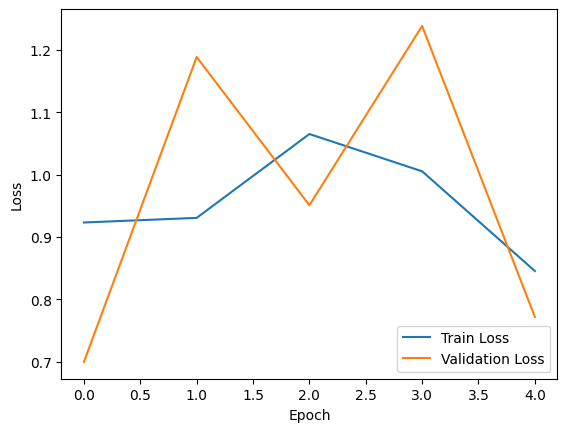

In [83]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [84]:
torch.save(cnn.state_dict(), './cnn_fruits.pth')

In [87]:
cnn_loaded = CNN()
cnn_loaded.load_state_dict(torch.load('./cnn_fruits.pth', weights_only=True))

<All keys matched successfully>

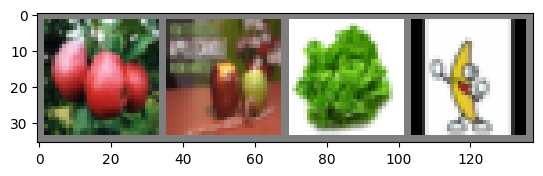

Predicho:  carrot carrot lettuce carrot
Verdadero:  apple apple lettuce banana


In [91]:
classes = ('apple', 'banana', 'carrot', 'lemon', 'lettuce')

dataiter = iter(valloader)

images, labels = next(dataiter)

imgs = torchvision.utils.make_grid(images)
img = imgs / 2 + 0.5
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

outputs = cnn_loaded(images)
_, predicted = torch.max(outputs, 1)

print('Predicho: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
print('Verdadero: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))